#**WQU Capstone**
**Group Number: 5468**


*   Track 1: Commodities - Research
*   Topic 1: Energy Products Relationships in Different Markets
*   Title: Understanding and Analyzing Energy Product Price Relationships Across Global Markets







In [41]:
pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 11.1 MB/s eta 0:00:00


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from arch import arch_model

#**STEP 1: Data Collection**


*   Collect historical price data for crude oil  (such as WTI, Bonny Light, Brent  etc) and their refined products (such as gasoline, diesel ect) from reliable sources.
*   Official websites and databases will be used.

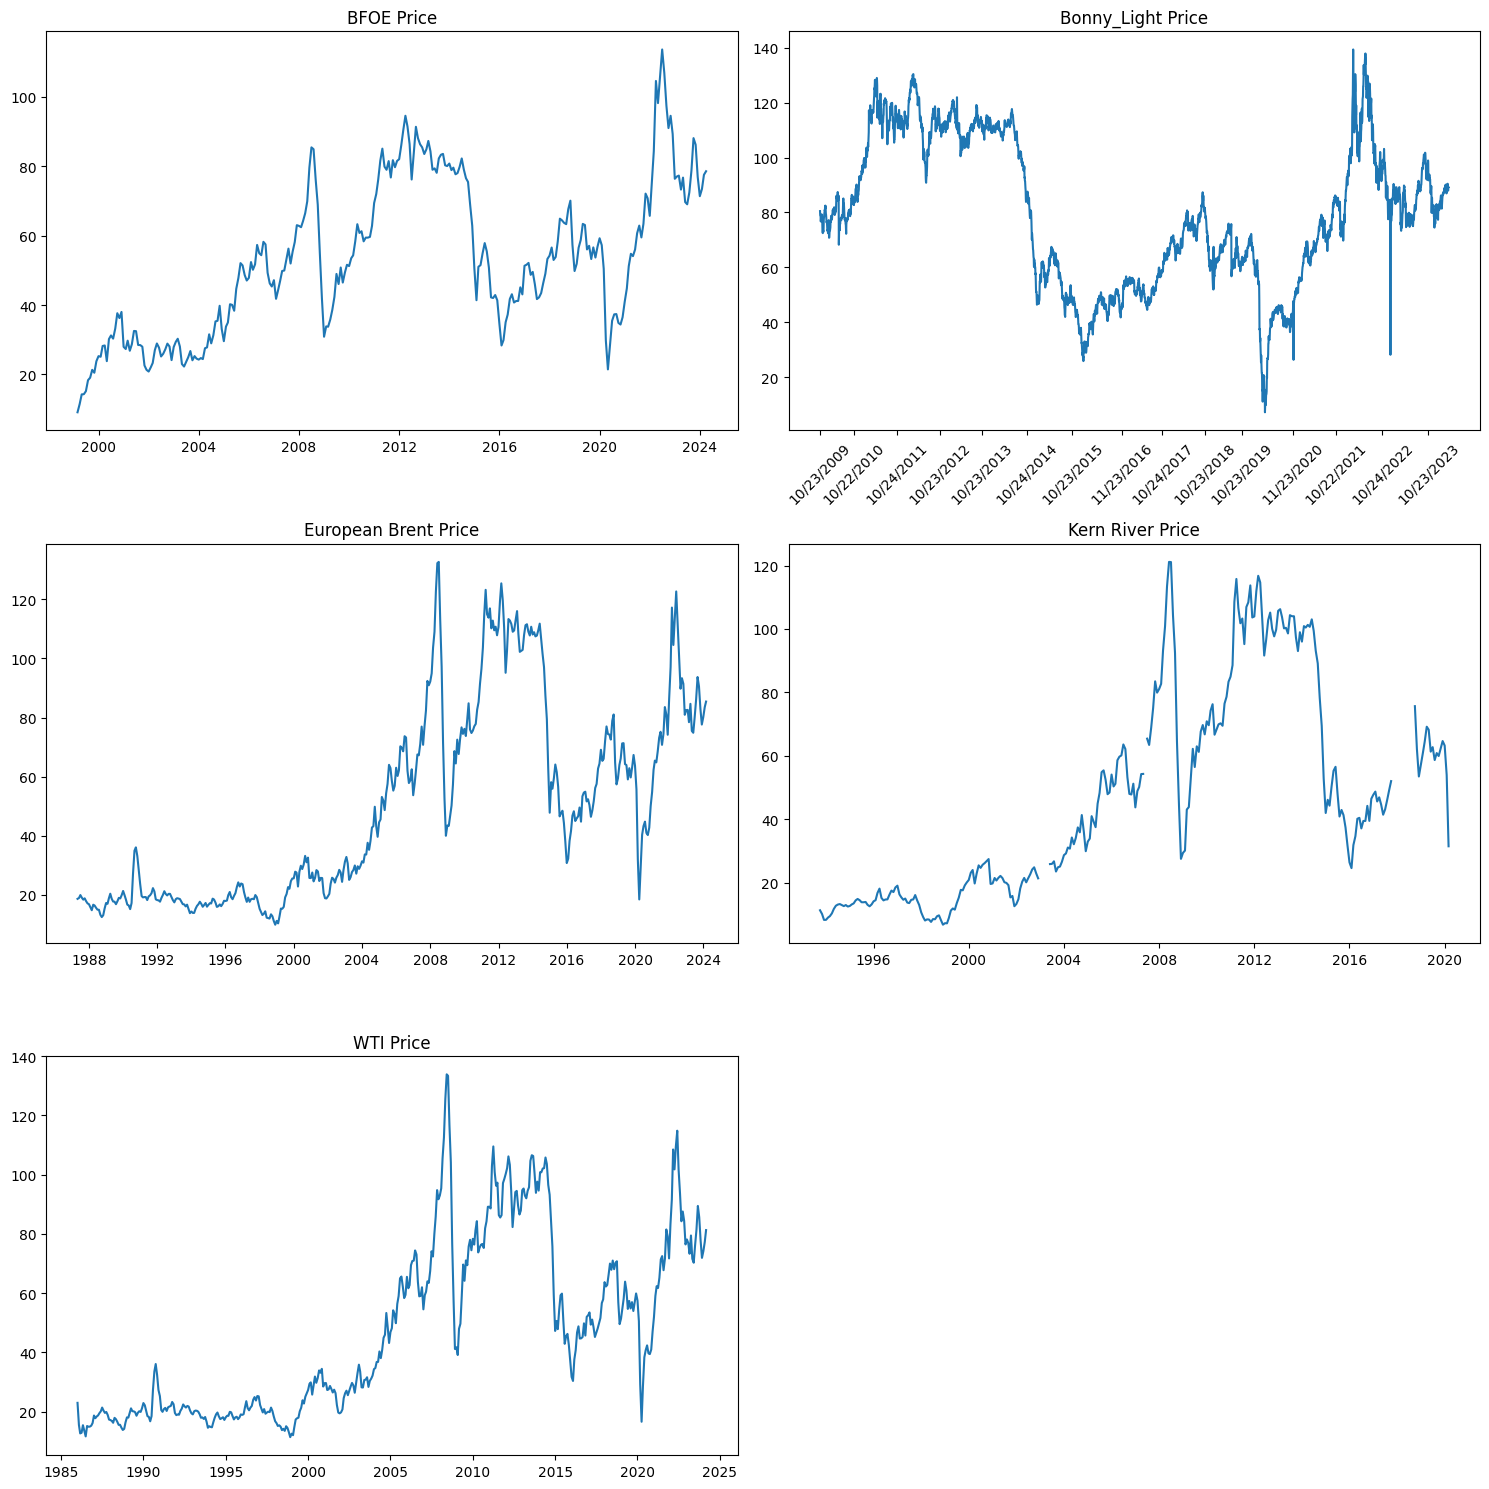

In [27]:
def collect_data():
    # Load data from CSV files
    BFOE_df = pd.read_csv("BFOE.csv")
    Bonny_Light_df = pd.read_csv("Bonny_Light.csv")
    Europe_Brent_df = pd.read_csv("Europe_Brent.csv", skiprows=4)
    Kern_River_df = pd.read_csv("Kern_River.csv", skiprows=4)
    WTI_df = pd.read_csv("WTI.csv", skiprows=4)

    # Convert 'Date' column to datetime format
    BFOE_df['Date'] = pd.to_datetime(BFOE_df['DATE'])
    Europe_Brent_df['Date'] = pd.to_datetime(Europe_Brent_df['Month'])
    Kern_River_df['Date'] = pd.to_datetime(Kern_River_df['Month'])
    WTI_df['Date'] = pd.to_datetime(WTI_df['Month'])

    # Set 'Date' column as index
    BFOE_df.set_index('Date', inplace=True)
    Bonny_Light_df.set_index('Date', inplace=True)
    Europe_Brent_df.set_index('Date', inplace=True)
    Kern_River_df.set_index('Date', inplace=True)
    WTI_df.set_index('Date', inplace=True)

    return BFOE_df, Bonny_Light_df, Europe_Brent_df, Kern_River_df, WTI_df

# Call the function to collect data
BFOE_df, Bonny_Light_df, Europe_Brent_df, Kern_River_df, WTI_df = collect_data()

# Subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

axs[0, 0].plot(BFOE_df.index, BFOE_df['Bloomberg European Dated Brent Forties Oseberg Ekofisk (BFOE) Crude Oil Spot Price'])
axs[0, 0].set_title('BFOE Price')

axs[0, 1].plot(Bonny_Light_df.index, Bonny_Light_df['Crude Oil Price in USD'])
axs[0, 1].set_title('Bonny_Light Price')
selected_dates = ['10/23/2009', '10/22/2010', '10/24/2011', '10/23/2012','10/23/2013','10/24/2014','10/23/2015','11/23/2016','10/24/2017','10/23/2018','10/23/2019','11/23/2020','10/22/2021','10/24/2022','10/23/2023']
axs[0, 1].set_xticks(selected_dates)
axs[0, 1].set_xticklabels(selected_dates, rotation=45)

axs[1, 0].plot(Europe_Brent_df.index, Europe_Brent_df['Europe Brent Spot Price FOB Dollars per Barrel'])
axs[1, 0].set_title('European Brent Price')

axs[1, 1].plot(Kern_River_df.index, Kern_River_df['California Kern River First Purchase Price Dollars per Barrel'])
axs[1, 1].set_title('Kern River Price')

axs[2, 0].plot(WTI_df.index, WTI_df['Cushing OK WTI Spot Price FOB Dollars per Barrel'])
axs[2, 0].set_title('WTI Price')

axs[2, 1].axis('off')

plt.tight_layout()
plt.show()


#**STEP 2: Data Preprocessing**


*   Clean & validate the data.
*   This includes handling missing values, and ensuring consistency.

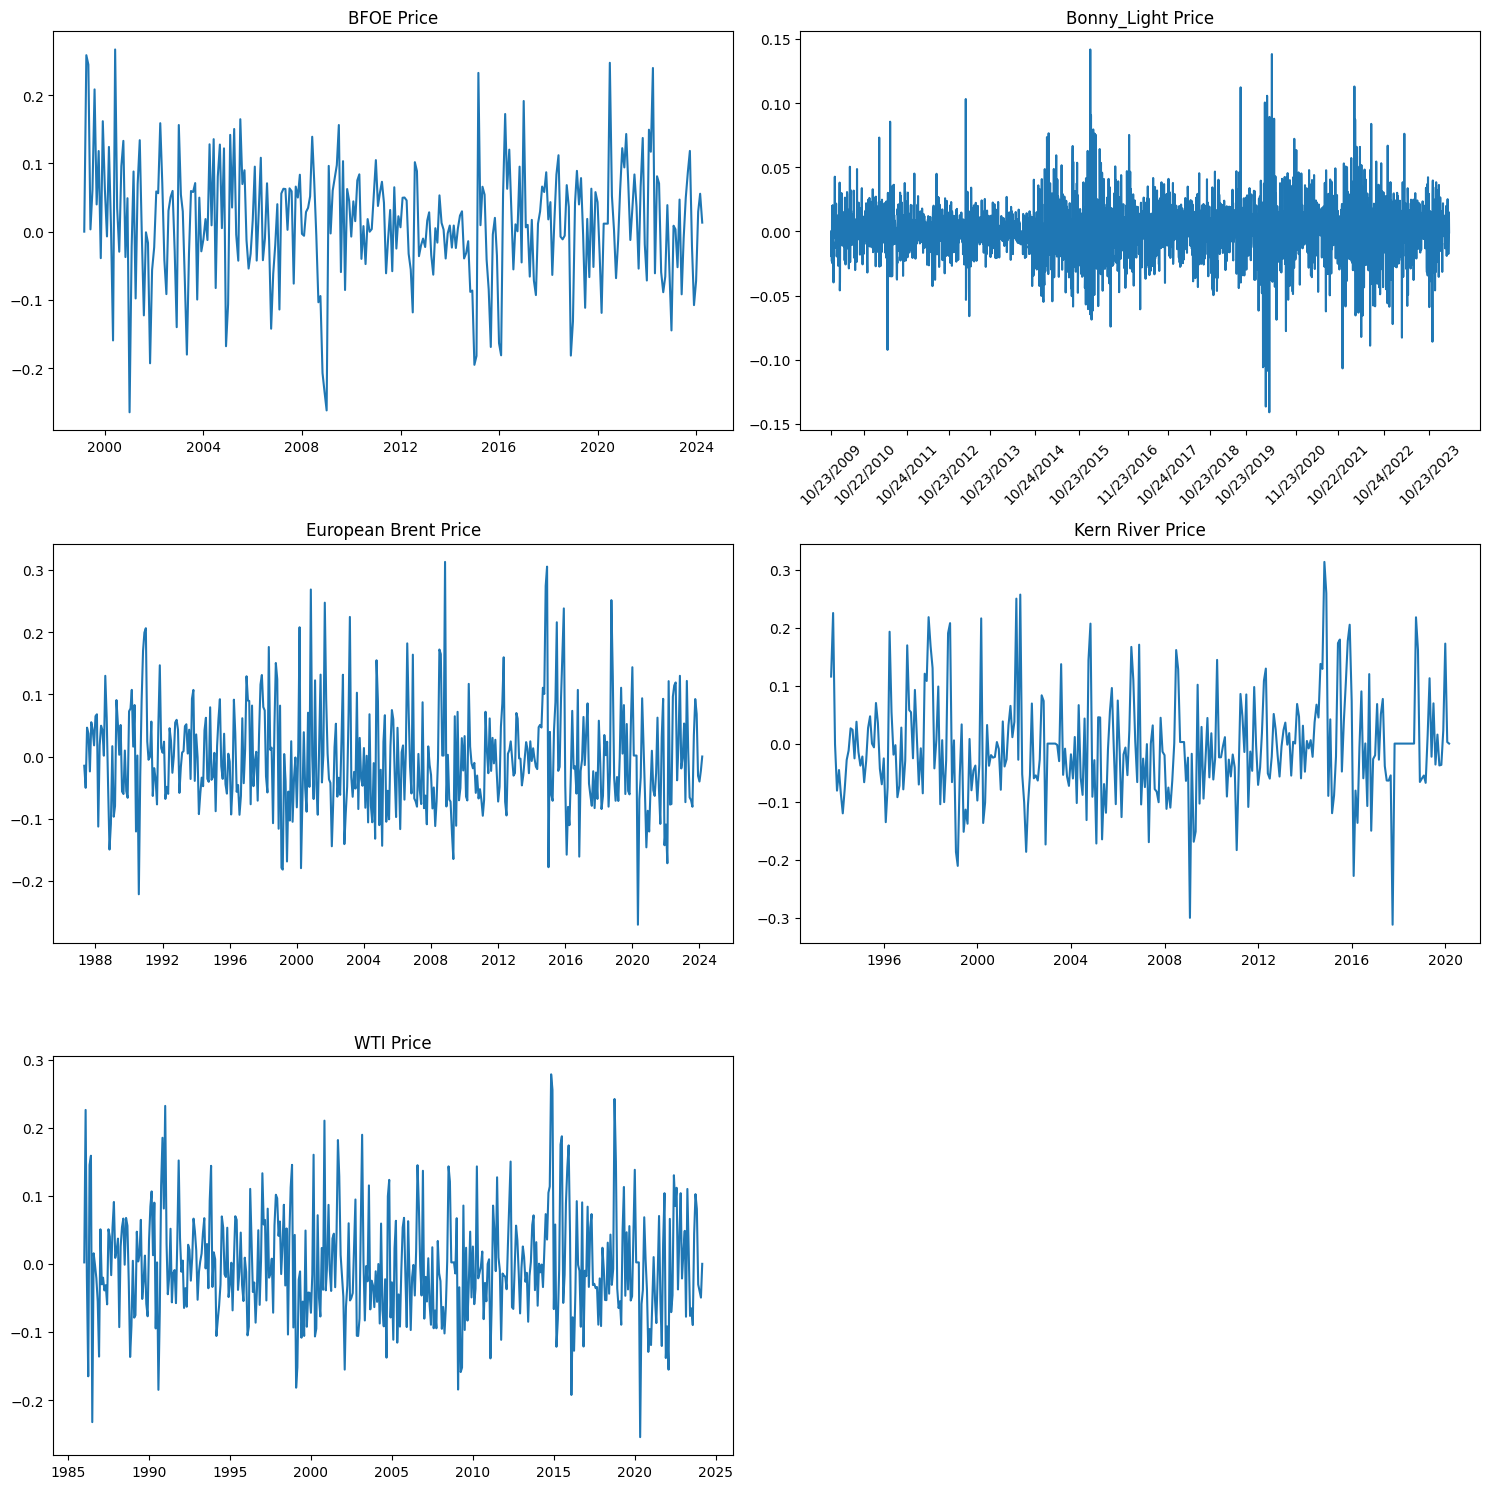

In [33]:
def preprocess_data(df, zero_handling=[], negative_handling=[], blank_handling='ffill', outlier_threshold=3):
    """
    Preprocesses the DataFrame by handling zero values, negative values, blank values, outliers, and NaN values.

    Parameters:
        df (DataFrame): Input DataFrame to be preprocessed.
        zero_handling (list): List of columns with zero values to be handled.
        negative_handling (list): List of columns with negative values to be handled.
        blank_handling (str): Method to handle blank values, options: 'ffill' (forward fill), 'bfill' (backward fill), 'mean' (fill with mean).
        outlier_threshold (float): Threshold value for determining outliers based on z-score.

    Returns:
        DataFrame: Preprocessed DataFrame.
    """
    # Handle NaN values
    df.fillna(method=blank_handling, inplace=True)

    # Handle zero values
    if zero_handling:
        for col in zero_handling:
            df[col] = df[col].replace(0, df[col].mean())

    # Handle negative values
    if negative_handling:
        for col in negative_handling:
            df[col] = df[col].apply(lambda x: max(0, x))

    # Define function for handling outliers
    def handle_outliers(series):
        """
        Replace outliers in the series with the mean value.

        Parameters:
            series (Series): Input Series to be processed.

        Returns:
            Series: Processed Series with outliers replaced by mean.
        """
        # Convert series to numeric values, coercing non-numeric values to NaN
        series_numeric = pd.to_numeric(series, errors='coerce')
        # Fill NaN values with 0.0
        series_numeric.fillna(0.0, inplace=True)
        # Compute percentage change
        series_pct_change = series_numeric.pct_change().fillna(0.0)
        # Compute mean and standard deviation
        mean = series_pct_change.mean()
        std = series_pct_change.std()
        # Compute z-score
        z_score = (series_pct_change - mean) / std
        # Replace outliers with the mean value
        series_pct_change[abs(z_score) > outlier_threshold] = mean
        return series_pct_change

    # Handle outliers
    for col in df.columns:
        df[col] = handle_outliers(df[col])

    return df

# Call the function to collect data
BFOE_df, Bonny_Light_df, Europe_Brent_df, Kern_River_df, WTI_df = collect_data()

# Preprocess data
BFOE_df_processed = preprocess_data(BFOE_df)
Bonny_Light_df_processed = preprocess_data(Bonny_Light_df)
Europe_Brent_df_processed = preprocess_data(Europe_Brent_df)
Kern_River_df_processed = preprocess_data(Kern_River_df)
WTI_df_processed = preprocess_data(WTI_df)

# Plot subfigures
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

axs[0, 0].plot(BFOE_df_processed.index, BFOE_df_processed['Bloomberg European Dated Brent Forties Oseberg Ekofisk (BFOE) Crude Oil Spot Price'])
axs[0, 0].set_title('BFOE Price')

axs[0, 1].plot(Bonny_Light_df_processed.index, Bonny_Light_df_processed['Crude Oil Price in USD'])
axs[0, 1].set_title('Bonny_Light Price')
selected_dates = ['10/23/2009', '10/22/2010', '10/24/2011', '10/23/2012','10/23/2013','10/24/2014','10/23/2015','11/23/2016','10/24/2017','10/23/2018','10/23/2019','11/23/2020','10/22/2021','10/24/2022','10/23/2023']
axs[0, 1].set_xticks(selected_dates)
axs[0, 1].set_xticklabels(selected_dates, rotation=45)

axs[1, 0].plot(Europe_Brent_df_processed.index, Europe_Brent_df_processed['Europe Brent Spot Price FOB Dollars per Barrel'])
axs[1, 0].set_title('European Brent Price')

axs[1, 1].plot(Kern_River_df_processed.index, Kern_River_df_processed['California Kern River First Purchase Price Dollars per Barrel'])
axs[1, 1].set_title('Kern River Price')

axs[2, 0].plot(WTI_df_processed.index, WTI_df_processed['Cushing OK WTI Spot Price FOB Dollars per Barrel'])
axs[2, 0].set_title('WTI Price')

axs[2, 1].axis('off')

plt.tight_layout()
plt.show()


#**STEP 3: Time Series Analysis**


*   Conduct EDA including time series plots, Q-Q analysis, and comparison of statistical metrics across markets.
*   Identify trends, seasonal patterns, and outliers.

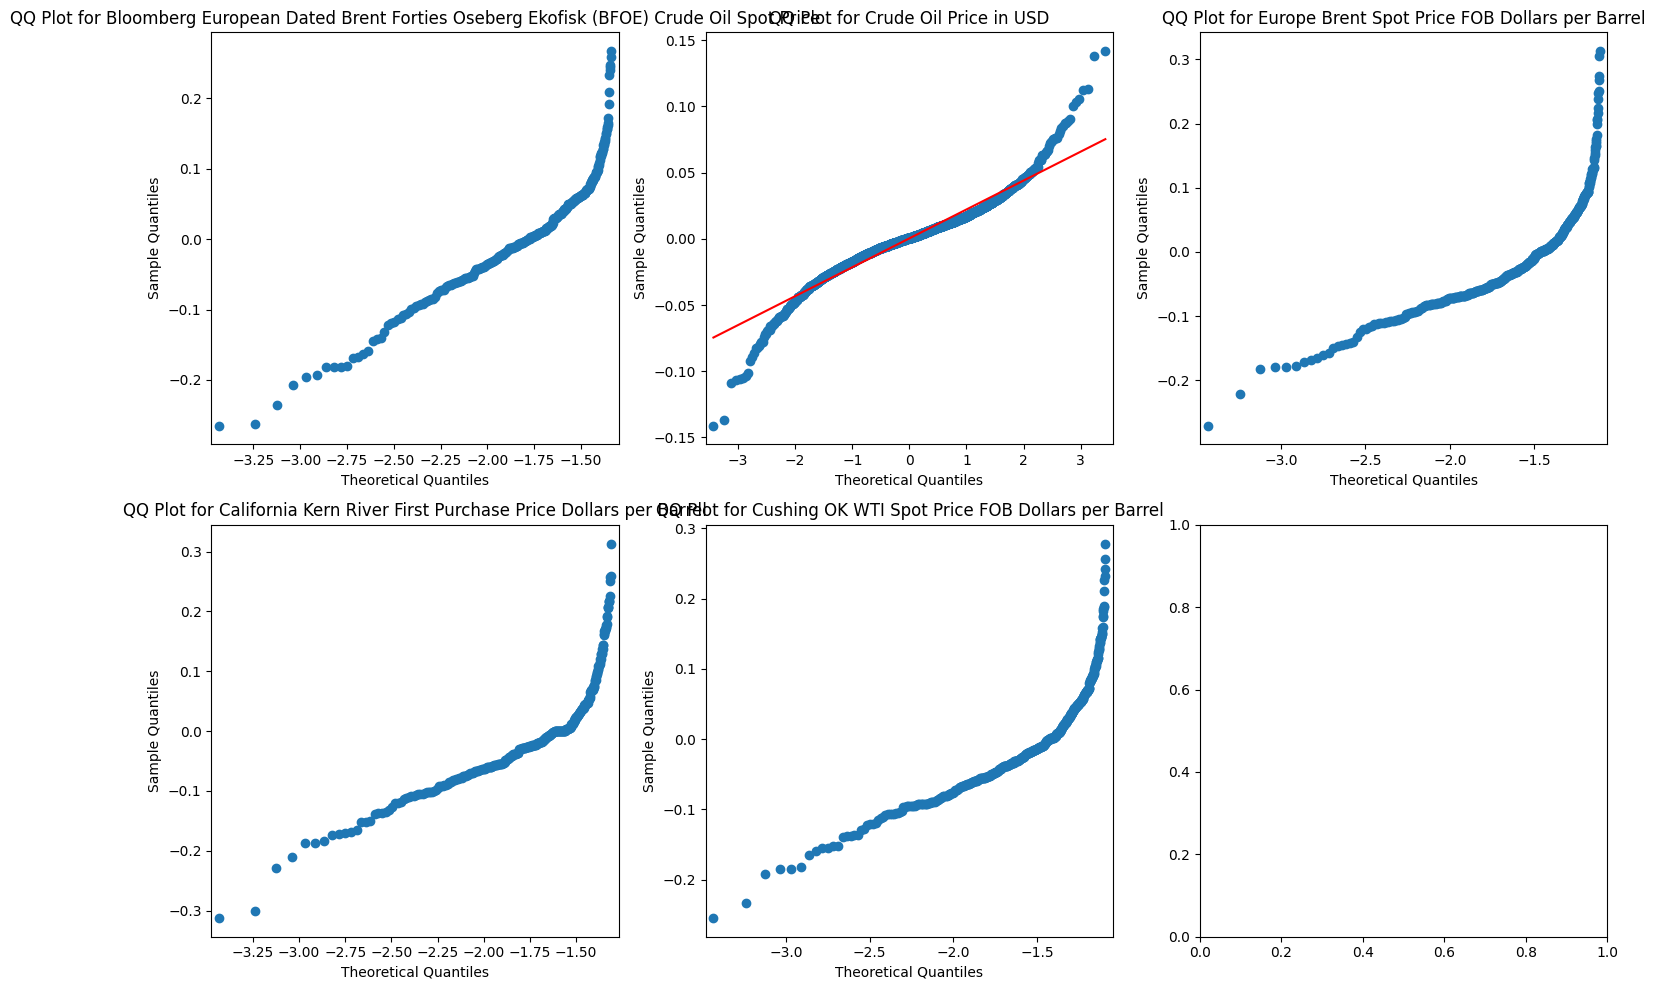

In [34]:
# Reset index
BFOE_df_processed.reset_index(drop=True, inplace=True)
Bonny_Light_df_processed.reset_index(drop=True, inplace=True)
Europe_Brent_df_processed.reset_index(drop=True, inplace=True)
Kern_River_df_processed.reset_index(drop=True, inplace=True)
WTI_df_processed.reset_index(drop=True, inplace=True)

# Concatenate the preprocessed DataFrames
all_processed_data = pd.concat([BFOE_df_processed, Bonny_Light_df_processed, Europe_Brent_df_processed, Kern_River_df_processed, WTI_df_processed], axis=1)

# Q-Q Analysis
price_columns = ['Bloomberg European Dated Brent Forties Oseberg Ekofisk (BFOE) Crude Oil Spot Price',
                 'Crude Oil Price in USD',
                 'Europe Brent Spot Price FOB Dollars per Barrel',
                 'California Kern River First Purchase Price Dollars per Barrel',
                 'Cushing OK WTI Spot Price FOB Dollars per Barrel']

# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

# Plot Q-Q plots for each price column
for i, col in enumerate(price_columns):
    sm.qqplot(all_processed_data[col], line='s', ax=axs[i])
    axs[i].set_title('QQ Plot for {}'.format(col))

plt.tight_layout()
plt.show()


#**STEP 4:Statistical Analysis**


*   Use statistical techniques to identify correlations between crude oil prices and their refined products.

In [35]:
# Concatenate the preprocessed DataFrames
all_processed_data = pd.concat([BFOE_df_processed, Bonny_Light_df_processed, Europe_Brent_df_processed, Kern_River_df_processed, WTI_df_processed], axis=1)

# Extract the columns related to crude oil prices and refined products
price_columns = ['Bloomberg European Dated Brent Forties Oseberg Ekofisk (BFOE) Crude Oil Spot Price',
                 'Crude Oil Price in USD',
                 'Europe Brent Spot Price FOB Dollars per Barrel',
                 'California Kern River First Purchase Price Dollars per Barrel',
                 'Cushing OK WTI Spot Price FOB Dollars per Barrel']

# Calculate the correlation matrix
correlation_matrix = all_processed_data[price_columns].corr()

# Display the correlation matrix
print("Correlation Matrix between Crude Oil Prices and Refined Products:")
print(correlation_matrix)


Correlation Matrix between Crude Oil Prices and Refined Products:
                                                    Bloomberg European Dated Brent Forties Oseberg Ekofisk (BFOE) Crude Oil Spot Price  \
Bloomberg European Dated Brent Forties Oseberg ...                                           1.000000                                    
Crude Oil Price in USD                                                                      -0.055353                                    
Europe Brent Spot Price FOB Dollars per Barrel                                               0.011911                                    
California Kern River First Purchase Price Doll...                                           0.101994                                    
Cushing OK WTI Spot Price FOB Dollars per Barrel                                             0.006880                                    

                                                    Crude Oil Price in USD  \
Bloomberg European Dated Br

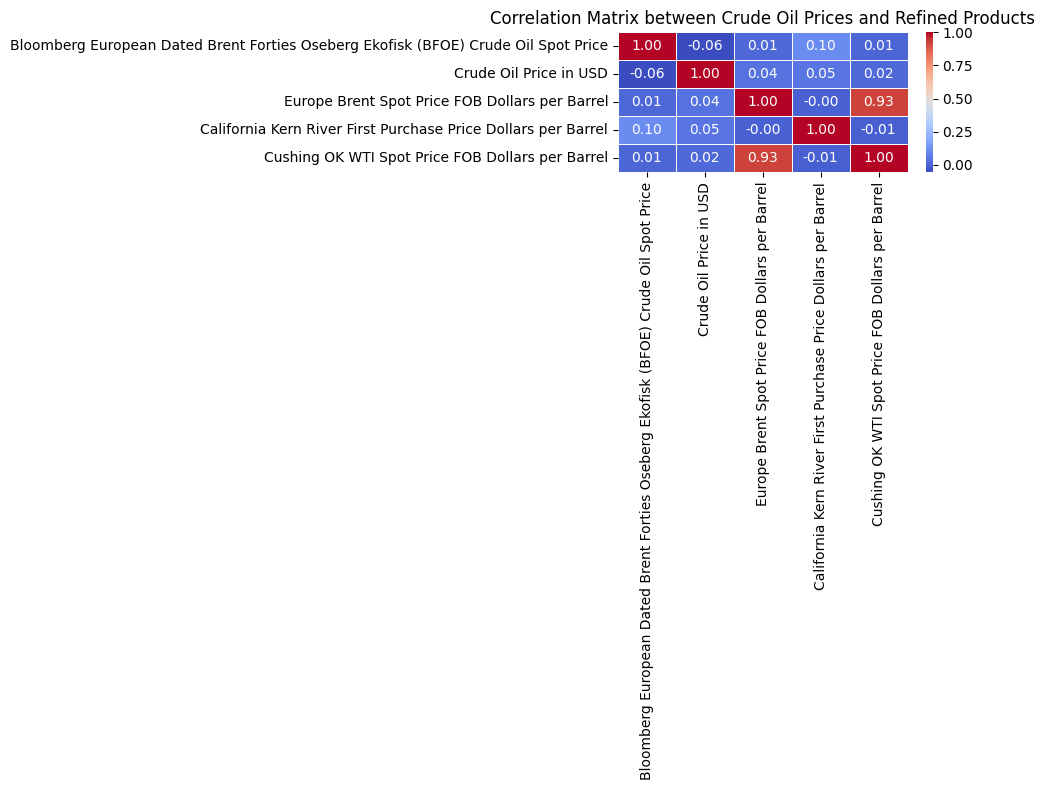

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Add title and adjust plot
plt.title('Correlation Matrix between Crude Oil Prices and Refined Products')
plt.tight_layout()

# Show plot
plt.show()


#**STEP 5:Model Development via Multivariate Techniques**


*   Use advanced statistical methodologies such as multivariate GARCH models, and Principal Component Analysis (PCA) to develop dynamic models for price relationship analysis.

In [39]:
# Extract the relevant columns for PCA
oil_prices_data = all_processed_data[['Bloomberg European Dated Brent Forties Oseberg Ekofisk (BFOE) Crude Oil Spot Price',
                                      'Crude Oil Price in USD',
                                      'Europe Brent Spot Price FOB Dollars per Barrel',
                                      'California Kern River First Purchase Price Dollars per Barrel',
                                      'Cushing OK WTI Spot Price FOB Dollars per Barrel']]

# Initialize SimpleImputer to replace NaN values with the mean
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the data and transform it
X_imputed = imputer.fit_transform(oil_prices_data)

# Create a PCA object
pca = PCA(n_components=5)

# Fit the PCA object to the data
pca.fit(X_imputed)

# Transform the data using the PCA object
X_transformed = pca.transform(X_imputed)

# Print the transformed data
print(X_transformed)


[[ 3.09506061e-03  5.95452695e-04 -1.41069344e-02 -1.12819264e-03
  -8.94638751e-04]
 [-4.53212721e-02 -1.12222913e-01  2.19575803e-01 -8.78183252e-03
   1.87626302e-02]
 [-5.28126172e-02 -2.59776944e-01  1.33829349e-01  1.09740448e-03
  -8.40689141e-04]
 ...
 [-5.37368998e-06  8.48756529e-06  4.91838537e-05 -9.28805279e-04
   6.27489293e-06]
 [ 8.39362739e-05 -1.32574564e-04 -7.68244807e-04  1.45078065e-02
  -9.80129359e-05]
 [-6.62151394e-06  1.04584619e-05  6.06048310e-05 -1.14448305e-03
   7.73198512e-06]]


In [57]:
import pandas as pd
from arch import arch_model

# Extract the relevant columns for GARCH modeling
oil_prices_data = all_processed_data[['Bloomberg European Dated Brent Forties Oseberg Ekofisk (BFOE) Crude Oil Spot Price',
                                      'Crude Oil Price in USD',
                                      'Europe Brent Spot Price FOB Dollars per Barrel',
                                      'California Kern River First Purchase Price Dollars per Barrel',
                                      'Cushing OK WTI Spot Price FOB Dollars per Barrel']]

# Drop rows with NaN values
oil_prices_data.dropna(inplace=True)

# Define a list to store the fitted models
fitted_models = []

# Fit separate GARCH models for each oil price series
for column in oil_prices_data.columns:
    oil_price_series = oil_prices_data[column]
    model = arch_model(oil_price_series, mean="Zero", vol="GARCH", p=1, q=1)
    model_fit = model.fit()
    fitted_models.append((column, model_fit))

# Print summaries for each fitted model
for column, model_fit in fitted_models:
    print(f"Summary for {column}:")
    print(model_fit.summary())

<ipython-input-57-f43033903945>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oil_prices_data.dropna(inplace=True)
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007556. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002409. Parameter
estimat

Iteration:      1,   Func. Count:      5,   Neg. LLF: 154329279.0573318
Iteration:      2,   Func. Count:     11,   Neg. LLF: -175.3237520328679
Iteration:      3,   Func. Count:     17,   Neg. LLF: -309.7315490681308
Iteration:      4,   Func. Count:     22,   Neg. LLF: -117.98083425683342
Iteration:      5,   Func. Count:     28,   Neg. LLF: -316.81722587933706
Iteration:      6,   Func. Count:     33,   Neg. LLF: -317.0167775844045
Iteration:      7,   Func. Count:     38,   Neg. LLF: -317.0276824888854
Iteration:      8,   Func. Count:     43,   Neg. LLF: -317.0356460320297
Iteration:      9,   Func. Count:     47,   Neg. LLF: -317.035646559523
Optimization terminated successfully    (Exit mode 0)
            Current function value: -317.035646559523
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 84.65170254821727
Iteration:      2,   Func. Count:     12,   Neg. LLF: -824.92621

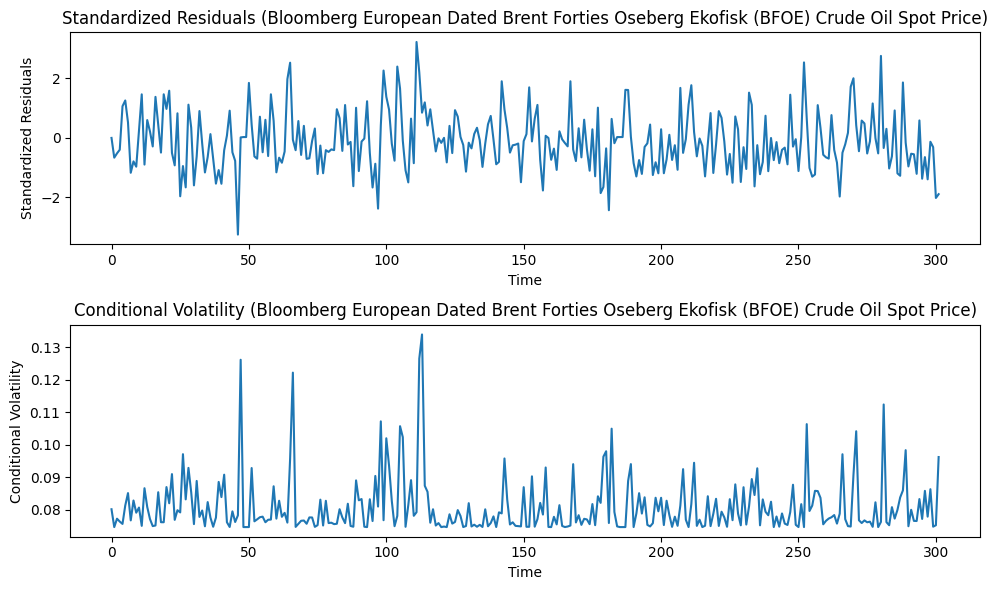

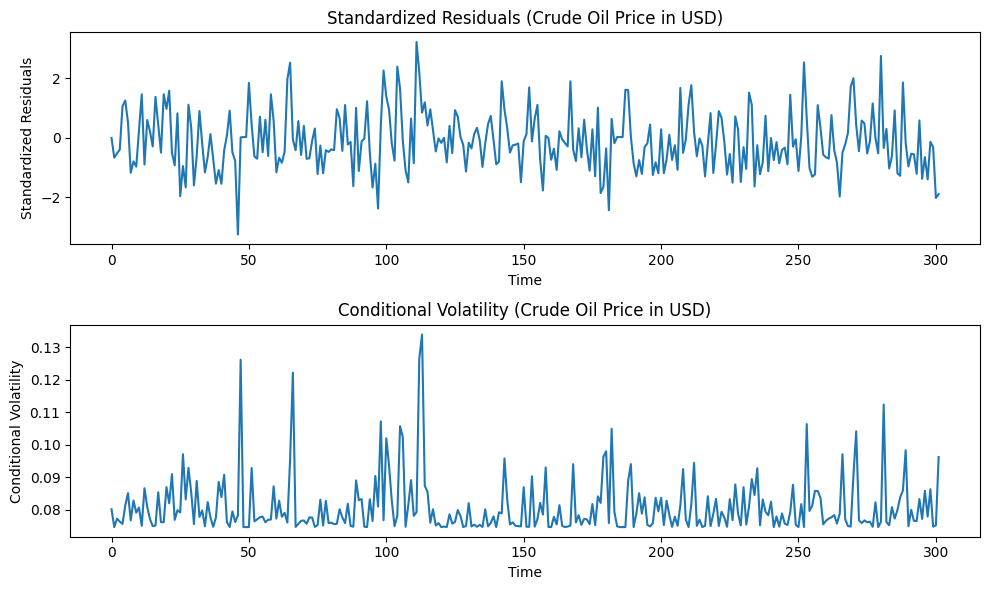

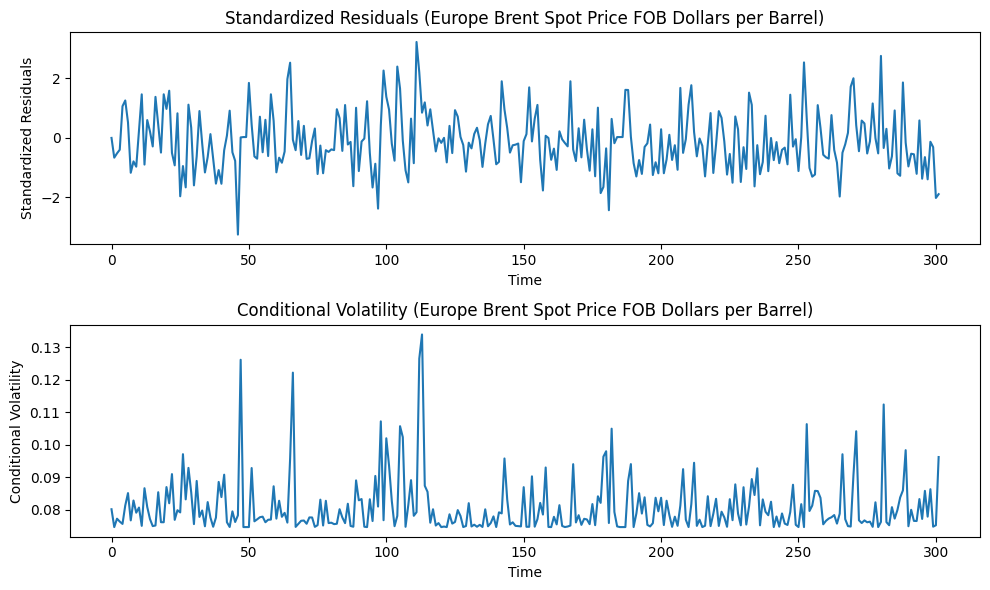

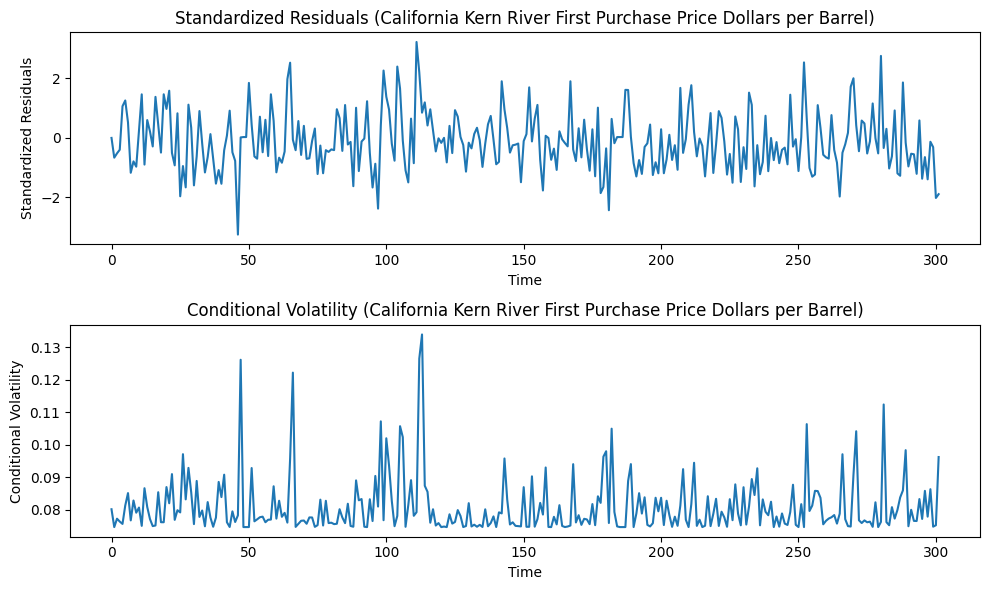

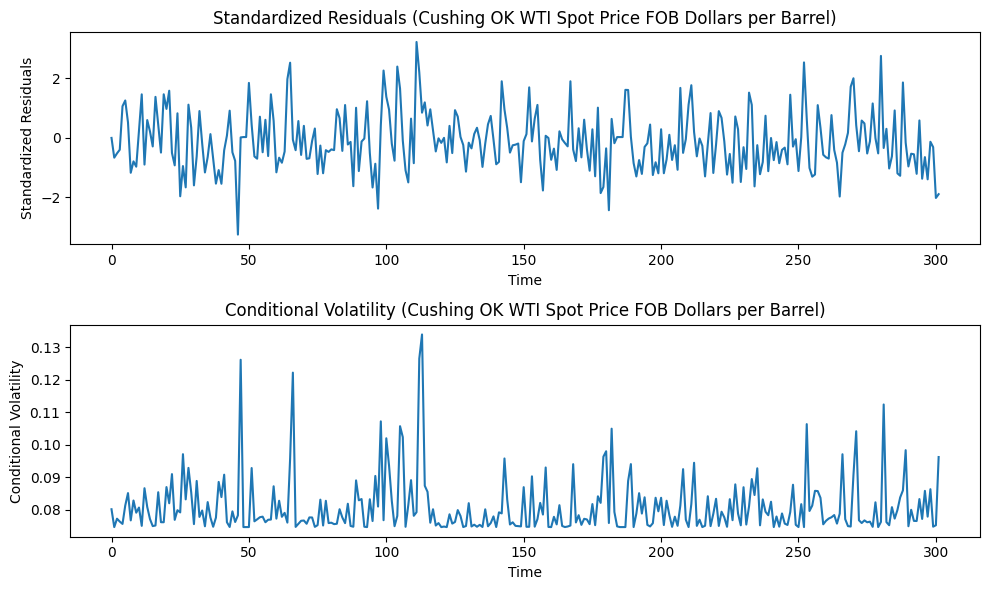

In [59]:
# Loop through each column of oil_prices_data
for i, column in enumerate(oil_prices_data.columns):
    # Select the column for GARCH modeling
    oil_price_series = oil_prices_data[column]

    # Plot the standardized residuals
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(model_fit.resid / model_fit.conditional_volatility)
    plt.title(f"Standardized Residuals ({column})")
    plt.xlabel("Time")
    plt.ylabel("Standardized Residuals")

    # Plot the conditional volatility
    plt.subplot(2, 1, 2)
    plt.plot(model_fit.conditional_volatility)
    plt.title(f"Conditional Volatility ({column})")
    plt.xlabel("Time")
    plt.ylabel("Conditional Volatility")

    plt.tight_layout()
    plt.show()


#**STEP 6:Result Interpretation**


*   Interpret the results of the analysis and provide insights into market dynamics and pricing relationships.

#**STEP 7:Discussion**


*   Discuss possible economic explanations for differences observed in price relationships across markets.